Open Data Science Course, topic 9: Time series

## Imports  

In [1]:
# Vectors, matrices, data manipulation, tables and plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
# Statistics, econometrics
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
# Function minimization for dates
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
# Nice progressbar and ..
from itertools import product
from tqdm import tqdm_notebook as tqdm
# Show plots inline
%matplotlib inline

Import metrics

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Import time series data splitter

In [3]:
from sklearn.model_selection import TimeSeriesSplit

## Read and visualize data

In [4]:
ads = pd.read_csv('data/ads.csv', index_col=["Time"], parse_dates=["Time"])
currency = pd.read_csv('data/currency.csv', index_col=["Time"], parse_dates=["Time"])


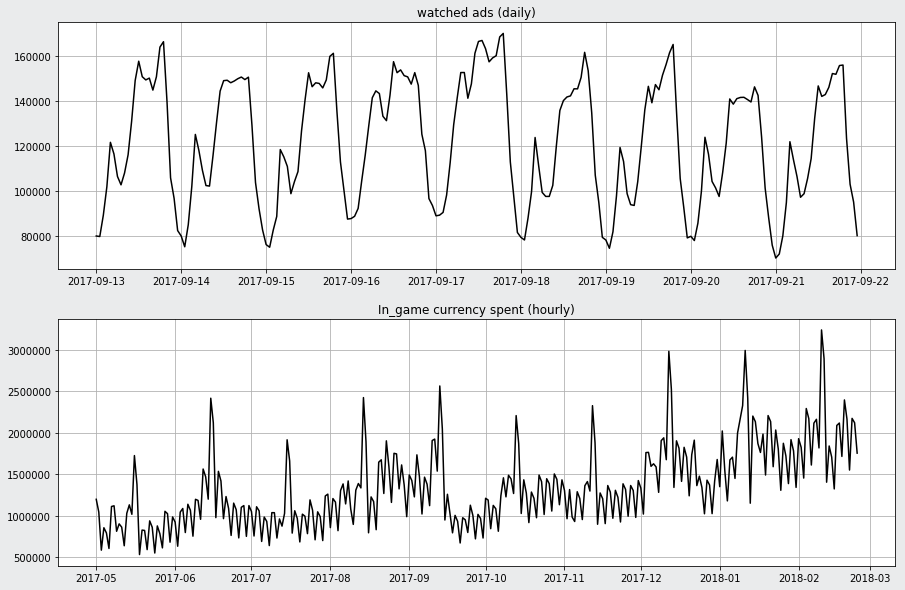

In [5]:
plt.figure(figsize=(15,10), facecolor='#eaebec')

plt.subplot(211)
plt.grid(True)
plt.title('watched ads (daily)')
plt.plot(ads.Ads, color='black')


plt.subplot(212)
plt.grid(True)
plt.plot(currency.GEMS_GEMS_SPENT, color='black')
plt.title('In_game currency spent (hourly)')

plt.show()

## Moving average

<p> Our motivation is a hypothesis: "tomorrow will be the same as today", which can be rephrased as<span style='color:red; font-family:serif; font-size:16px;'> the future value of our variable depends on the average of its $k$ previous values. </span></p>


Therefore we use the **moving average**


$$
\hat{y}_{t}=\sum_{n=1}^{k}{y_{t-n}}
$$



In [6]:
def moving_average(series, n):
    return np.average(series[-n:])

In [7]:
print(f'Prediction for the last 24 hours: {moving_average(ads, 24)}')
print(f'Prediction for the last 48 hours: {moving_average(ads, 48)}')
print(f'Prediction for the last 72 hours: {moving_average(ads, 72)}')
print(f'Prediction for the last 96 hours: {moving_average(ads, 96)}')
print(f'Prediction for the last 120 hours: {moving_average(ads, 120)}')

Prediction for the last 24 hours: 116805.0
Prediction for the last 48 hours: 116293.75
Prediction for the last 72 hours: 116908.26388888889
Prediction for the last 96 hours: 117163.02083333333
Prediction for the last 120 hours: 120824.16666666667


_Moving average_ is unable to make predictions far in the future. But it has another use case - **smoothing the original time series to identify trends**.

There is an implementation of the moving average in _Pandas_: `pandas.DataFrame.rolling(window).mean()`

Wider window ------> Smoother trend. If the data is very noisy (finances for example), moving average can help detect common patterns

In [8]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
    Description: Perform the plot of the moving average with pandas and matplotlib.pyplot.
        
    Arguments:
    -----------------------------------
        series : pandas.Series or pandas.DataFrame with pandas.Series.
                DataSeries to be plotted.
        window : int.
                Rolling window size. The wider is the window, the smoother is trend.
        scale  : float.
                Scalling multiplier
        plot_intervals : boolean, default : False. 
                Show confidence intervals.
        plot_anomalies : boolean, default : False. 
                Show anomalies in the time series.
    
    """
    # Find the moving average for the stated window with pandas implementation
    rolling_mean = series.rolling(window).mean()
    # Plot rolling mean, set the size of the figure and the title, add grid
    plt.figure(figsize=(15,5))
    plt.title(f'Moving average for the window of size {window} ')
    plt.grid()
    plt.plot(rolling_mean, c='g', label='Rolling mean trend')
    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        # Mean absolute error
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        # Set the deviation 
        deviation = np.std(series[window:] - rolling_mean[window:])
        # Set the lower and upper bonds
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        # Plot the upper and lower bonds
        plt.plot(upper_bound, 'r--', label = 'Upper Bound')
        plt.plot(lower_bound, 'r--', label = 'Lower Bound')
        
    # Find abnormal values (anomalies)
    if plot_anomalies:
        # Get the index and name of columns from the original series
        anomalies = pd.DataFrame(index=series.index, columns=series.columns)
        # Set all outbound values as abnormal
        anomalies[series < lower_bound] = series[series < lower_bound]
        anomalies[series > upper_bound] = series[series > upper_bound]
        # Plot the anomalies
        plt.plot(anomalies, 'ro', markersize=10)
    
    # Plot the actual values 
    plt.plot(series[window:], label='Actual values')
    # Place legend in the upper left corner
    plt.legend(loc='upper left')    

Smooth by the previous 2, 4, 8, 12, 24, 36 and 72 hours. With the previous 24 hours we get the daily trend

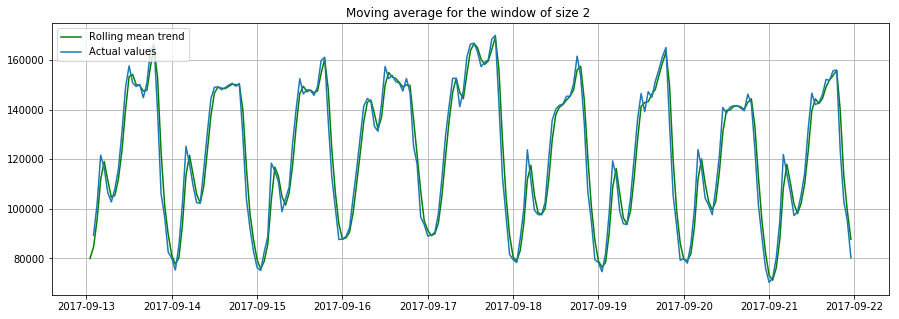

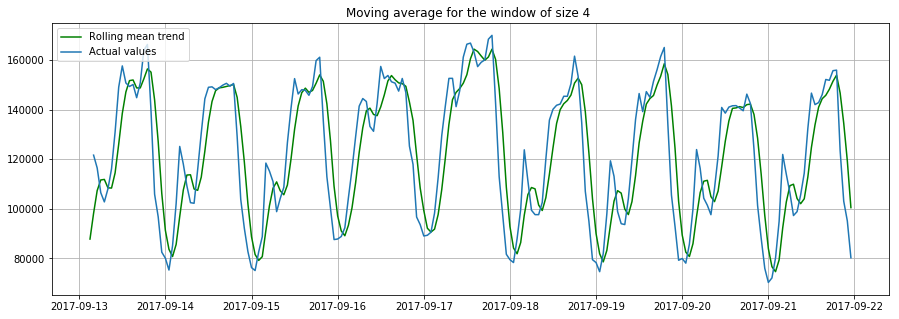

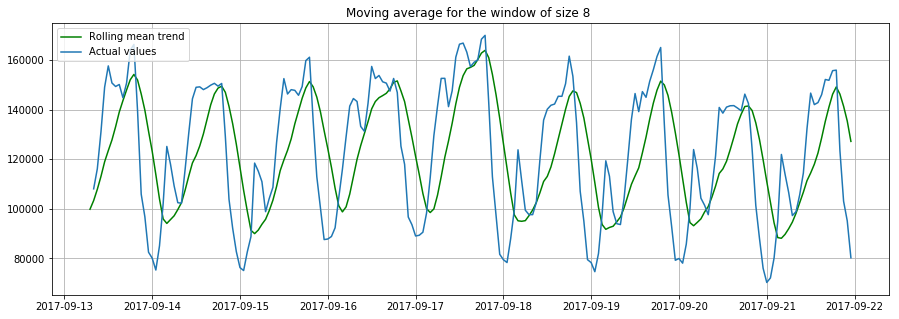

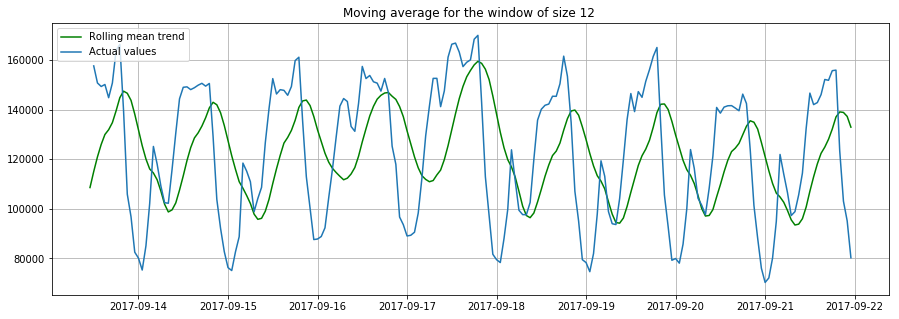

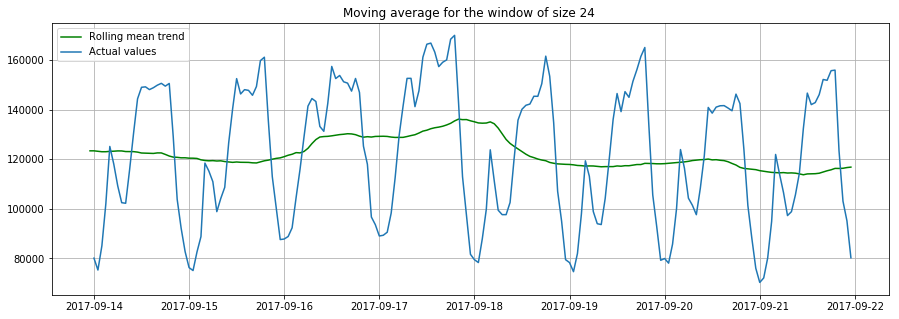

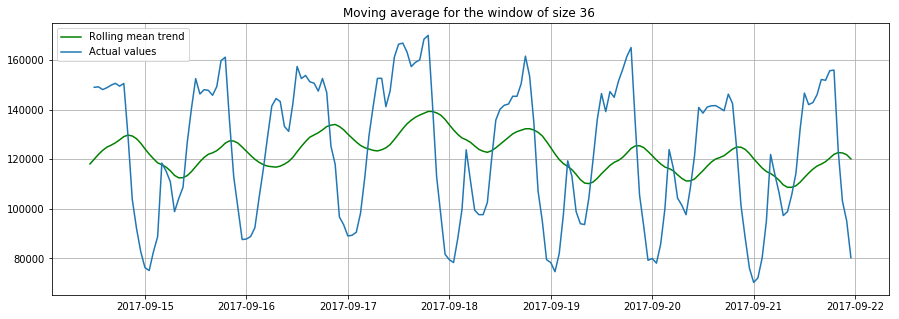

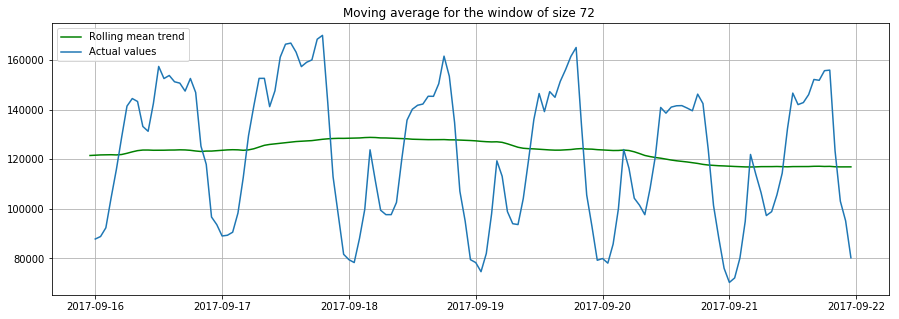

In [9]:
plot_moving_average(ads,2)
plot_moving_average(ads, 4)
plot_moving_average(ads, 8)
plot_moving_average(ads, 12)
plot_moving_average(ads, 24)
plot_moving_average(ads, 36)
plot_moving_average(ads, 72)
plt.show()

Plot the same, this time with intervals for our smoothed values

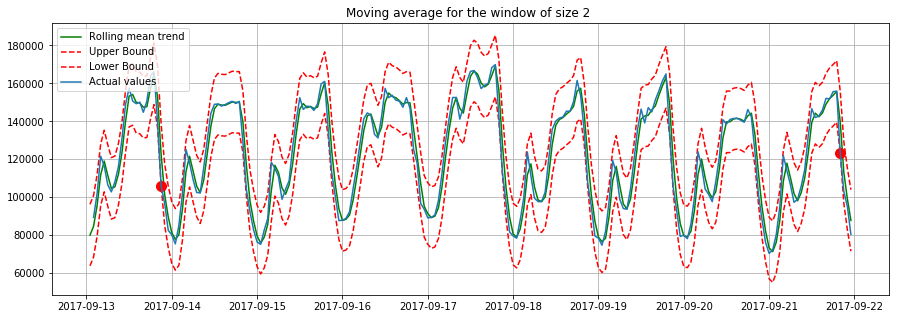

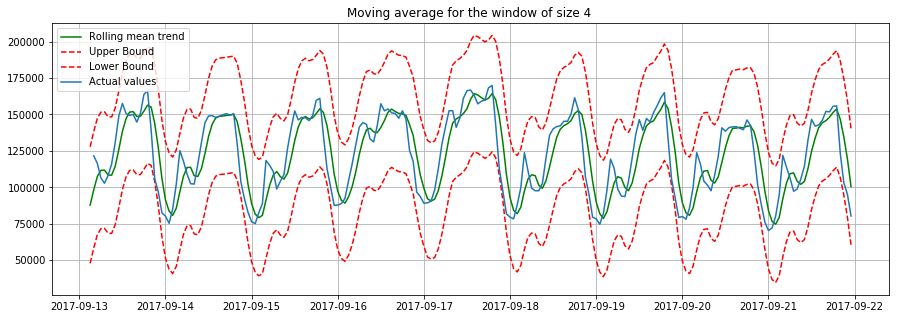

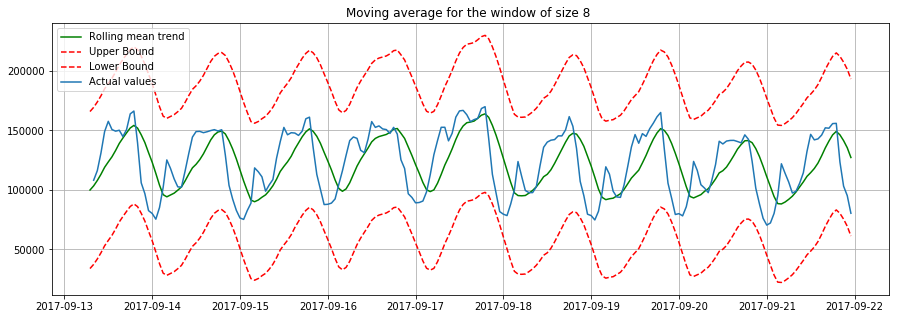

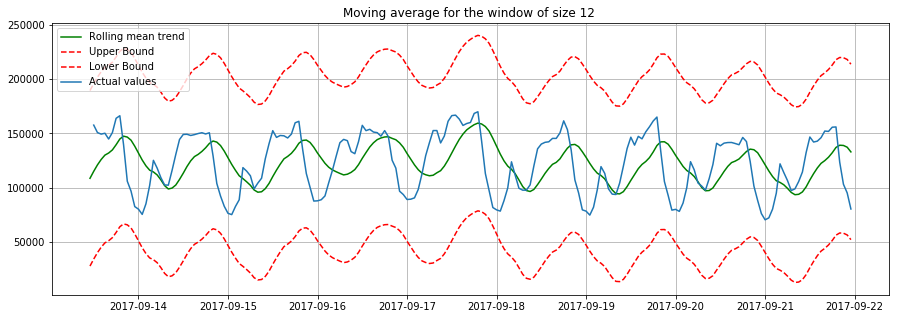

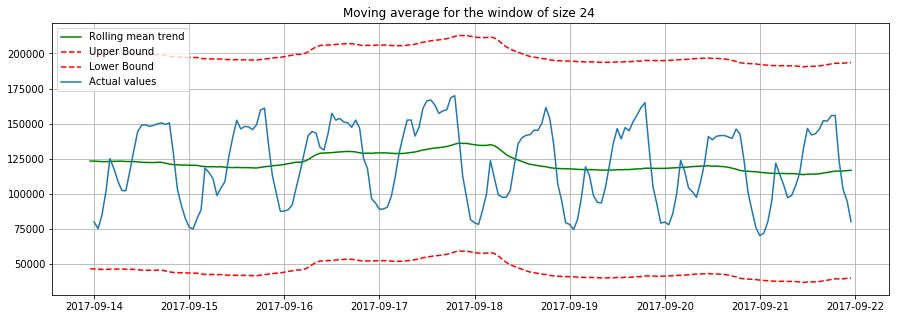

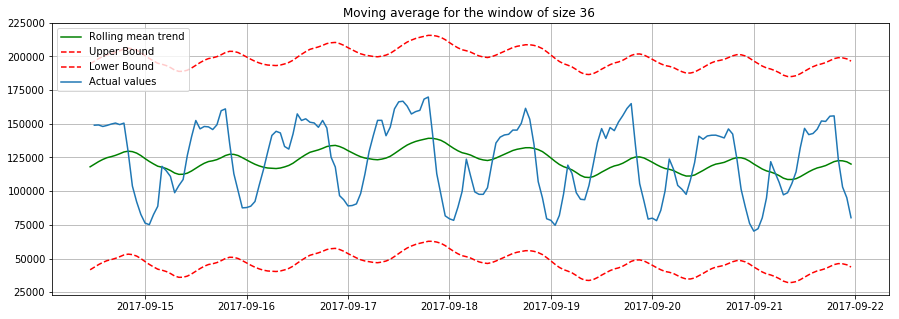

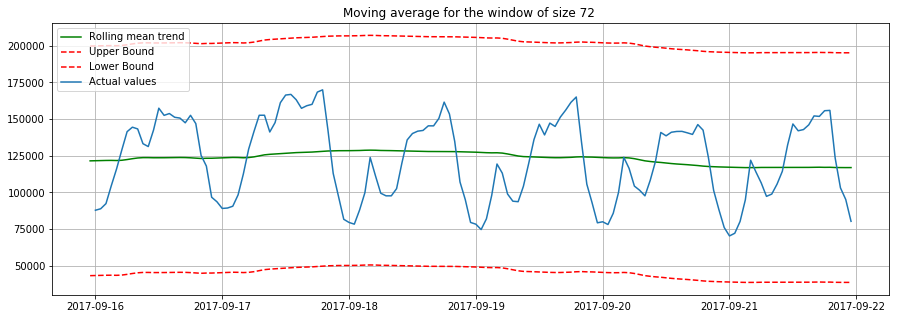

In [10]:
plot_moving_average(ads,2, plot_intervals=True, plot_anomalies=True)
plot_moving_average(ads, 4, plot_intervals=True, plot_anomalies=True)
plot_moving_average(ads, 8, plot_intervals=True, plot_anomalies=True)
plot_moving_average(ads, 12, plot_intervals=True, plot_anomalies=True)
plot_moving_average(ads, 24, plot_intervals=True, plot_anomalies=True)
plot_moving_average(ads, 36, plot_intervals=True, plot_anomalies=True)
plot_moving_average(ads, 72, plot_intervals=True, plot_anomalies=True)
plt.show()

Try plotting moving average for the currency

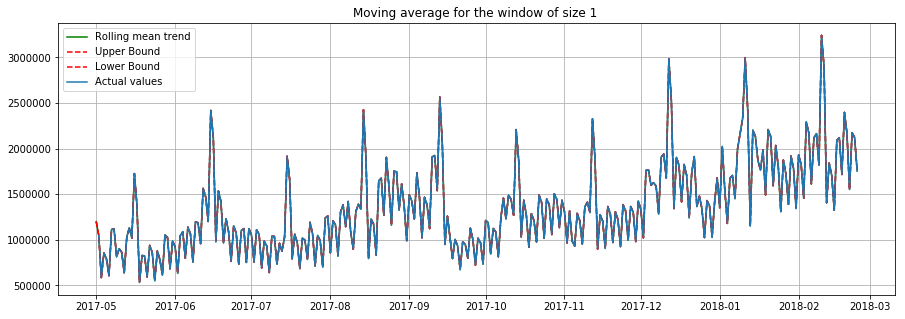

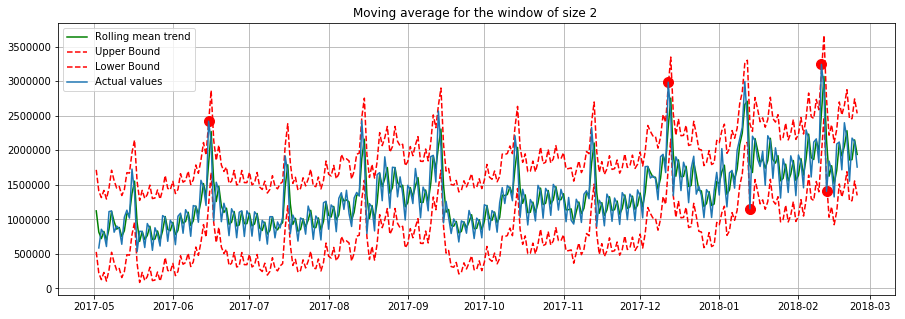

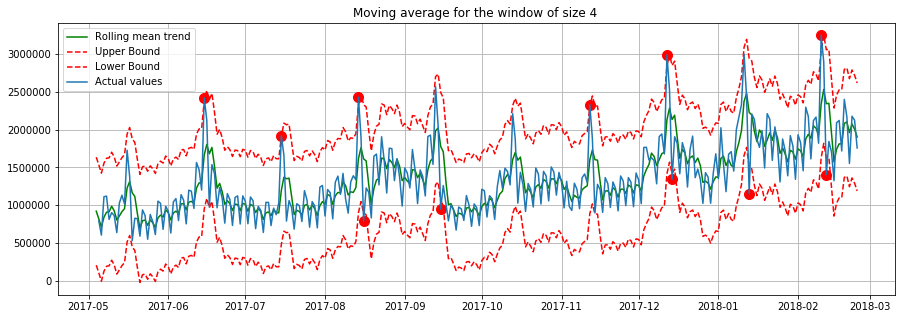

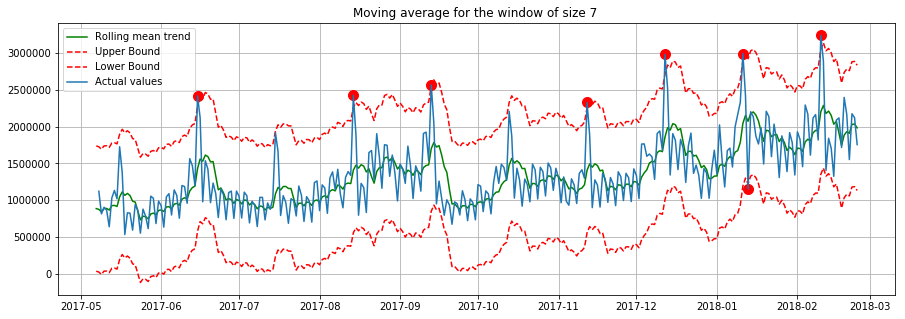

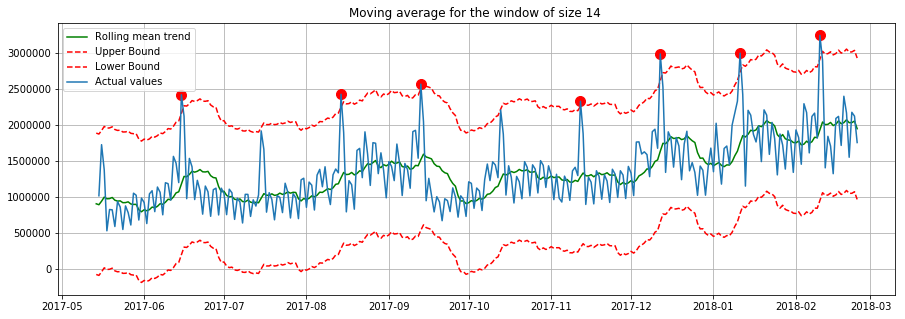

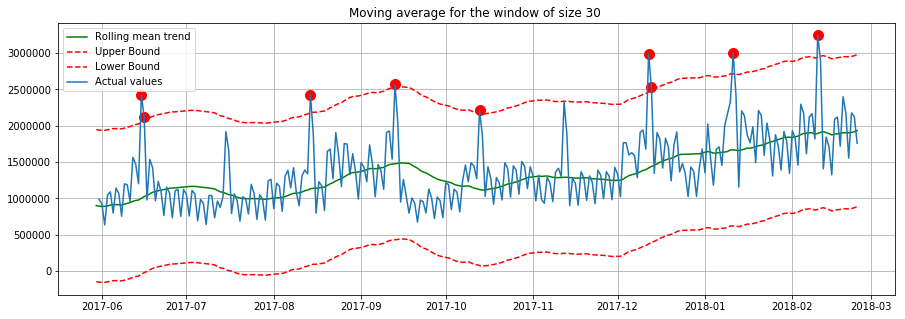

In [11]:
plot_moving_average(currency, 1, plot_intervals=True, plot_anomalies=True) 
plot_moving_average(currency, 2, plot_intervals=True, plot_anomalies=True) 
plot_moving_average(currency, 4, plot_intervals=True, plot_anomalies=True) 
plot_moving_average(currency, 7, plot_intervals=True, plot_anomalies=True)
plot_moving_average(currency, 14, plot_intervals=True, plot_anomalies=True)
plot_moving_average(currency, 30, plot_intervals=True, plot_anomalies=True) 

plt.show()

As we can see on the plot above, the moving average didn\`t capture the monthly seasonality in our data. Let\`s consider more complex approach to avoid false positives. 

## Weighted average

It is a simple modification of the moving average. The weights sum up to 1, larger weights are assigned to more recent observations.


$$
    \hat{y}_t = \sum_{n=1}^{k}{\omega_{n} y_{t+1-n}}
$$

In [12]:
def weighted_average(series, weights):
    """
    Description:
        Calculate weighted average on series.
        
    Arguments:
    ----------------------------------------------
        series : pandas.DataFrame or pandas.Series
        weights : list, tuple or any other iterable.
        
    Return:
        Weighted average on series of type 'float'
    """
    # Initialize a float
    result = 0.0
    # Reverse the list of weights
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

Check, if the weighted average computes well

In [13]:
weighted_average(ads, [0.6, 1.2, 0.1])

184062.5

## Exponential smoothing

Used if we start weighting all available observations instead the last $k$ observations.

Model value is a weighted average between the current true value and the previous model values:

$$
    \hat{y}_t = \alpha \cdot {y}_t + (1 - \alpha)\cdot \hat{y}_{t-1}
$$

$\alpha$ - smoothing factor. The larger the $\alpha$, the less influence previous observations have.

Function is exponential, because of recursion.  

In [14]:
def exponential_smoothing(series, alpha=0.3):
    """
        Description: Performs exponential smoothing for series.
                    Learn more about exponential smoothing: https://en.wikipedia.org/wiki/Exponential_smoothing
        
        Arguments:
        ----------------------------------------------
            series : pandas.DataFrame or pandas.Series
            alpha : float, default : 0.3
            
        Return: 
            Exponential smoothing for series with smoothing factor alpha
        
    """
    # First value should be the same as series
    result = [series[0]]
    # Range begins from 1, because the zeroth value is assigned above
    for n in range(1, len(series)):
        # Add new values
        result.append(alpha * series[n] + (1 - alpha) * result[-1])
    return result

Perform the plot for exponential smoothing

In [15]:
def plot_exponential_smoothing(series, alphas):
    """
        Description:
                Plots exponential smoothing with different smoothing factors.
                Requires import matplotlib.pyplot as plt
        Arguments:
        ----------------------------------------------
            series : pandas.DataFrame or pandas.Series.
                    x, y for the plot
            alphas : list, tuple or any iterable.
                   Array of floats, smoothing parameters
        
    """
    # Choose the style of plotting
    with plt.style.context('ggplot'): 
        # Plot the backgroung figure
        plt.figure(figsize=(15, 10))
        # Loop over the iterable of alphas to plot the line for every smoothing factor alpha
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        # Add legend, set the axis properties etc.
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

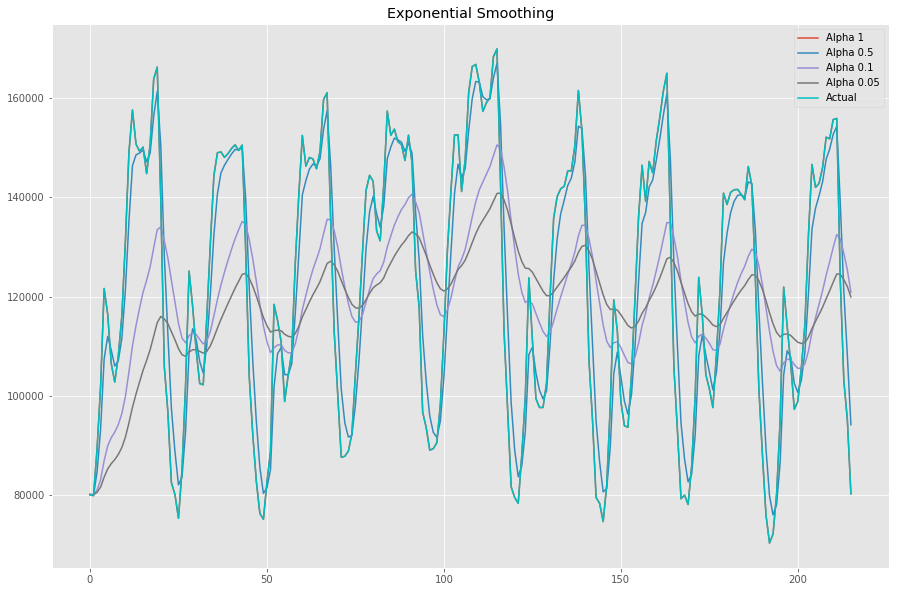

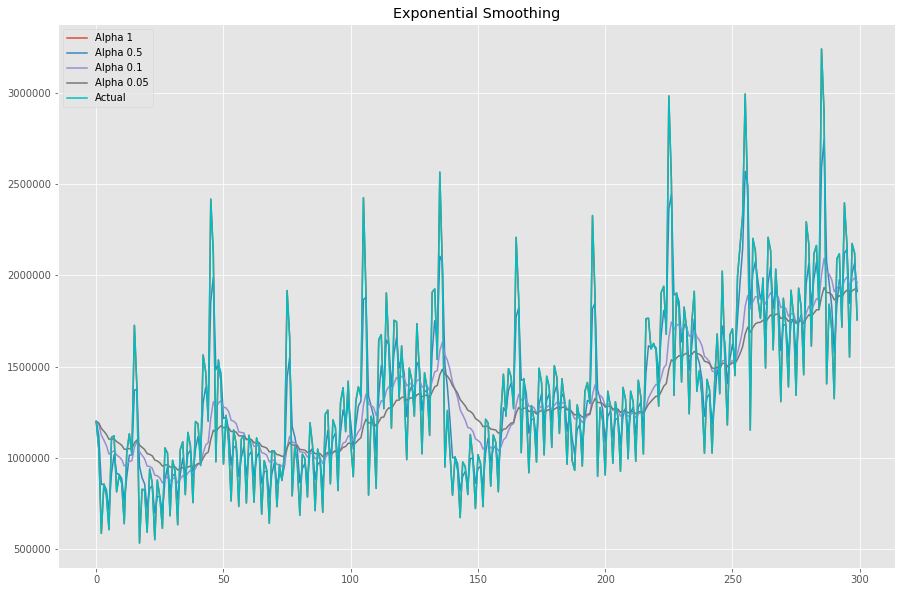

In [16]:
plot_exponential_smoothing(ads.Ads, [1,0.5,0.1, 0.05])
plot_exponential_smoothing(currency.GEMS_GEMS_SPENT,[1,0.5,0.1, 0.05])

## Double exponential smoothing

   
Methods, discussed above, work well for a single future point prediction with nice smoothing. Double exponential smoothing lets us predict two future points. To perform it, use the `series decomposition`: two components $l$ - intercept and $b$ - slope.

Apply the same as for level (intercept) exponential smoothing to the trend (slope), assuming that _`future direction of time series changes, depending on the previous weighted changes`_:



$$

    \hat{y}_{x+1} = l_{x} + b_{x}, where

    l_{x} = \alpha \cdot y_{x} + (1 - \alpha)(l_{x-1}+b_{x-1}) -- intercept, depends on the current value of the series.
    
    b_{x} = \beta \cdot (l_{x} - l_{x-1}) + (1 - \alpha)(l_{x-1} + b_{x-1}) -- slope, depends on the level changes at current step and on the previous trend value.
    
    \beta - weight for exponential smoothing

    
$$

In [17]:
def double_exponential_smoothing(series, alpha, beta):
    """
        Description:
            Perform double exponential smoothing as the sum of two parameters, describinh slope and intercept.
            
        Arguments:
        ----------------------------------------------
            series : pandas.DataFrame or pandas.Series.
                    Dataset with timeseries
            alpha  : float in range [0.0, 1.0]
                    Smoothing parameter for level (intercept)
            beta   : float in range [0.0, 1.0]
                    Smoothing parameter for trend (slope)
    
        Return : sum of the slope and intercept of type float
    """
    # First value should be the same as series
    result = [series[0]]
    # Loop over the series, omit the zeroth element, as it has been already included
    for n in range(1, len(series)+1):
        # Perform substraction
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        # Count the trend
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        # Count the slope
        trend = beta*(level-last_level) + (1-beta)*trend
        # Add level to trend
        result.append(level+trend)
    return result

Perform plotting

In [25]:
def plot_double_exponential_smoothing(series, alphas, betas):
    """
        Description:
            Plot the double exponential smoothing. Requires import matplotlib.pyplot
            
        Arguments:
        ----------------------------------------------
            series : pandas.DataFrame or pandas.Series.
                    Dataset with timeseries
            alpha  : 
                alpha should consist of floats in range [0.0, 1.0] only
            beta   : float in range [0.0, 1.0]
                beta should consist of floats in range [0.0, 1.0] only    
    """
    # Select a style
    with plt.style.context('seaborn-white'):
        # Create a figure
        plt.figure(figsize=(20, 10))
        # Plot actual values of series, set legend, add title and grid
        plt.plot(series.values, label = "Actual", c='black')
        # Loop over exponential smoothing parameters
        for alpha in alphas:
            for beta in betas:
                # Plot the double exponential smoothing for the actual value of trend and level.
                plt.plot(double_exponential_smoothing(series, alpha, beta), label=f'Intercept: {alpha}, Slope: {beta}')
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

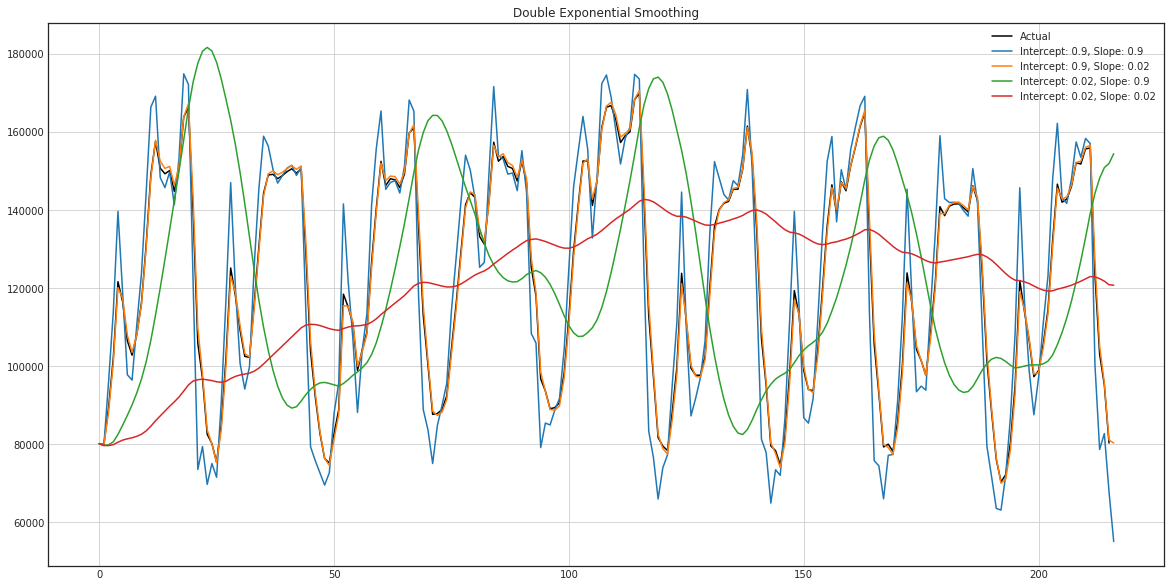

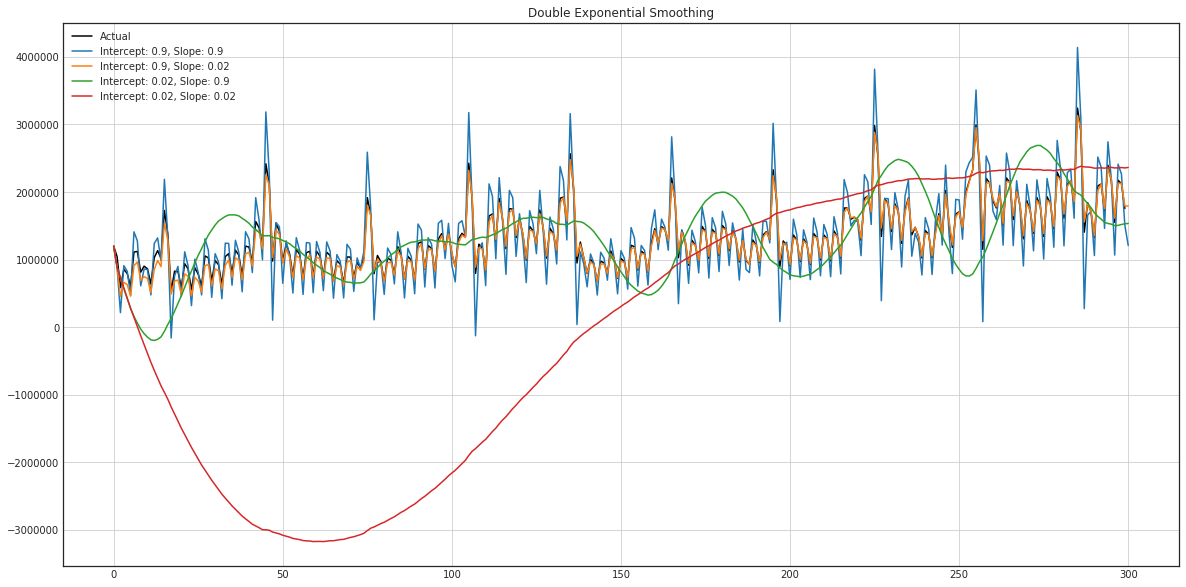

In [26]:
plot_double_exponential_smoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])
plot_double_exponential_smoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Triple exponential smoothing (Holt-Winters exponential smoothing)

`Series decomposition`:
 * $l$ - intercept (level)
 * $b$ - slope (trend)
 * $s$ - seasonality
 
 **NB**: Do not use **seasonality** if the time series expected not to have seasonality. Seasonal components in the model depend on the length of the season and there is a single component for every observation in the season. For example, for daily seasonality (24 hours) we have 24 components.



$\hat{y}_{x+m} = l_{x} + m\cdot b_{x} + s_{x-L+1+(m-1)\%L}$, where

$l_{x} = \alpha \cdot (y_{x}-s_{x-L}) + (1 - \alpha)(l_{x-1}+b_{x-1})$ -- intercept, depends on the current value of the series.

$b_{x} = \beta \cdot (l_{x} - l_{x-1}) + (1 - \beta)b_{x-1}$ -- slope, depends on the level changes at current step and on the previous trend value.

$ s_{x} = \gamma\cdot(y_{x}-l_{x}) + (1-\gamma\cdot s_{x-L})$ -- seasonal components, depends on the current value of intercept, previous value of the seasonality and current value of the level (intercept)



#### Triple exponential smoothing uses Brutlag method to produce confidence intervals

$$
\hat{y}_{max_{x}} = l_{x-1} + b_{x-1} + s_{x-T} + m\cdot d_{t-T}
$$
$$
\hat{y}_{min_{x}} = l_{x-1} + b_{x-1} + s_{x-T} - m\cdot d_{t-T}
$$
                         Where
$$
d_{t} = \gamma |y_{t} - \hat{y}_{t}| + (1 - \gamma ) d_{t-T}
$$
_T_ - length of the season, _d_ - predicted deviation

In [20]:
class HoltWinters:
    """
    Triple exponential smoothing model with anomalities detection with Brutlag method
    
    Arguments:
    -----------------------------------------------
        series : 
                Initial time series
        s_len   : 
                Length of the current season
        alpha  : 
                intercept (level) coefficient
        beta   : 
                Slope (trend) coefficient.
        gamma  : 
                Seasonal coefficient.
        num_preds : 
                Prediction_horizon
        scale  : 
                Width of the confidence interval by Brutlag (usually 2 <= scale <= 3) 
        
    """
    
    def __init__(self, series, s_len, alpha, beta, gamma, num_preds, scale=1.96):
        self.series = series
        self.s_len = s_len
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.num_preds = num_preds
        self.scale = scale
        
    def initial_trend(self):
        # Initialize initial value for the initial trend
        sum = 0.0
        for i in range(self.s_len):
            # Update initial trend with every iteration
            sum += float(self.series[i + self.s_len] - self.series[i]) / self.s_len
        return sum / self.s_len
    
    def initial_seasonal_components(self):
        # Initialize dict of seasonal components and list of averages for every season 
        seasonal_components = {}
        season_averages = []
        num_seasons = int(len(self.series) / self.s_len)
        # Calculate season averages
        for j in range(num_seasons):
            season_averages.append(sum(self.series[self.s_len * j : self.s_len * j + self.s_len]) / float(self.s_len))
        # Calculate initial values
        for i in range(self.s_len):
            over_avg_vals = 0.0
            for j in range(num_seasons):
                over_avg_vals += self.series[self.s_len * j + i] - season_averages[j]
            # Update list of season averages
            seasonal_components[i] = over_avg_vals / num_seasons
        return seasonal_components
    
    def triple_exp_smoothing(self):
        # Define lists of all the values
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBound = []
        self.LowerBound = []
        # Get seasonal components as dicts
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.num_preds):
            # components initialization
            if i == 0: 
                # Get smooth and trend
                smooth = self.series[0]
                trend = self.initial_trend()
                # Update lists of result, smooth, trend, season, predicted deviation
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.s_len])
                
                self.PredictedDeviation.append(0)
                # update upper and lower bounds
                self.UpperBound.append(self.result[0] + 
                                      self.scale * 
                                      self.PredictedDeviation[0])
                
                self.LowerBound.append(self.result[0] - 
                                      self.scale * 
                                      self.PredictedDeviation[0])
                # Go to the next iteration
                continue
            # predicting
            if i >= len(self.series): 
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.s_len])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.s_len]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.s_len] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.s_len]
                self.result.append(smooth+trend+seasonals[i%self.s_len])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBound.append(self.result[-1] + 
                                  self.scale * 
                                  self.PredictedDeviation[-1])

            self.LowerBound.append(self.result[-1] - 
                                  self.scale * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.s_len])

## Training

Function to perform training and return time series cross-validation score. 

In the models of exponential smoothing there is a constraint on the size of smoothing parameters ($\alpha, \beta, \gamma$): each of them should be in range $[0,1]$. Thats why instead of stochastic gradient descent we use the _**truncated Newton conjugate**_ gradient (**TNC**). 

In [28]:
def timeseries_cv_score(params, series, loss_function=mean_squared_error, s_len=24):
    """
    Description: Get the time series error on cross-validation. Requires imported numpy as np and pandas libraries.
    
    Arguments:
        params : list, tuple or any other iterable
                1D vector of parameters for optimization: alpha, beta and gamma
        series : pandas.Series or pandas.DataFrame 
                Dataset with parameters
        loss_function : function
                Loss function. Preferably one of the following: MSE, MSPE, MSRE, MLSE, r2_score, MAE
        s_len  : int
                Season length for Holt-Winters model.
    
    Return : Mean of errors
    
    """
    # List of errors
    errors = []
    # Reassign variables for the convenience
    values = series.values
    alpha, beta, gamma = params
    # Number of folds for time series cross-validation
    ts_cv = TimeSeriesSplit(n_splits=3)
    
    # Iterate over folds
    for train, test in ts_cv.split(values):
        # Perform training of the triple exponential smoothing model
        model = HoltWinters(series=values[train], s_len=s_len, alpha=alpha, beta=beta, gamma=gamma,num_preds=len(test))
        model.triple_exp_smoothing()
        # Predict 
        y_pred = model.result[-len(test):]
        # Get actual values of time series for the test period to compare with predicted
        y_test = values[test]
        # Calculate an error between actual and forecasted values
        error = loss_function(y_pred, y_test)
        errors.append(error)
        print(error)
    return np.mean(np.array(errors))

In [34]:
%%time

# leave the last 20 points for validation
data = ads.Ads[:-20]

# Initialize model parameters (alpha, beta, gamma)
x = [0,0,0]

# Minimize the loss function
opt = minimize(timeseries_cv_score, x0=x, args=(data, mean_squared_log_error),
                   method='TNC', bounds=((0,1),(0,1),(0,1)))
# Retrieve optimal values
alpha_final, beta_final, gamma_final = opt.x
print(opt.x)

# Train the model to forecast ads watching for the next 50 hours
model = HoltWinters(data, s_len=24, alpha=alpha_final, beta=beta_final, gamma=gamma_final, num_preds=50, scale=3)

model.triple_exp_smoothing()



0.47104415829864643
0.5858057169565306
0.7110076026297252
0.47104415829864643
0.5858057169565306
0.7110076026297252
0.4710435999164474
0.5858041430500036
0.7110040708877171
0.47104415829864643
0.5858057169565306
0.7110076026297252
0.4710441351561095
0.5858056488312227
0.7110074505733863
0.47104273667704977
0.5858017095360646
0.7109986103563353
0.47104273667704977
0.5858017095360646
0.7109986103563353
0.4710421782971515
0.5858001356445156
0.710995078678943
0.47104273667632196
0.5858017095331451
0.7109986103474861
0.4710427135346011
0.5858016414113996
0.7109984583027706
0.3851435595182162
0.3782955289587608
0.33209825627082096
0.3851435595182162
0.3782955289587608
0.33209825627082096
0.38514313424530755
0.37829465345226887
0.3320969676326234
0.38514351955634246
0.3782954106878077
0.33209801476749834
0.38514354154569524
0.37829549061754075
0.3320982002452717
0.16564911198909865
0.07420502583915292
0.02222333258486817
0.16564911198909865
0.07420502583915292
0.02222333258486817
0.1656489734

0.041769412854128794
0.013432243556646782
0.01054735724993106
0.004878892932046364
0.013432243556646782
0.01054735724993106
0.004878892932046364
0.013432242470527107
0.010547357411998456
0.004878892639713453
0.013432220540126931
0.010547369647817755
0.00487890075838148
0.013432243464810149
0.010547357274279029
0.004878892929554154
0.011767986214327359
0.011021867155898814
0.004461180838805414
0.011767986214327359
0.011021867155898814
0.004461180838805414
0.011767986107989185
0.011021867173840377
0.004461180737392842
0.011767967757849834
0.01102188011926025
0.004461186092543711
0.011767986155749397
0.011021867187904676
0.004461180852004865
0.011590267901276959
0.011135645551328502
0.004389196940540328
0.011590267901276959
0.011135645551328502
0.004389196940540328
0.011590267913169468
0.01113564554567169
0.004389196886486419
0.011590250478588578
0.011135658269474111
0.004389201603966184
0.011590267835208603
0.011135645586769672
0.004389196949327175
0.011590267895716043
0.0111356455488330

In [39]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBound[:len(series)]] = \
            series.values[series.values<model.LowerBound[:len(series)]]
        anomalies[series.values>model.UpperBound[:len(series)]] = \
            series.values[series.values>model.UpperBound[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBound, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBound, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBound, 
                         y2=model.LowerBound, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBound), ymax=max(model.UpperBound), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13)

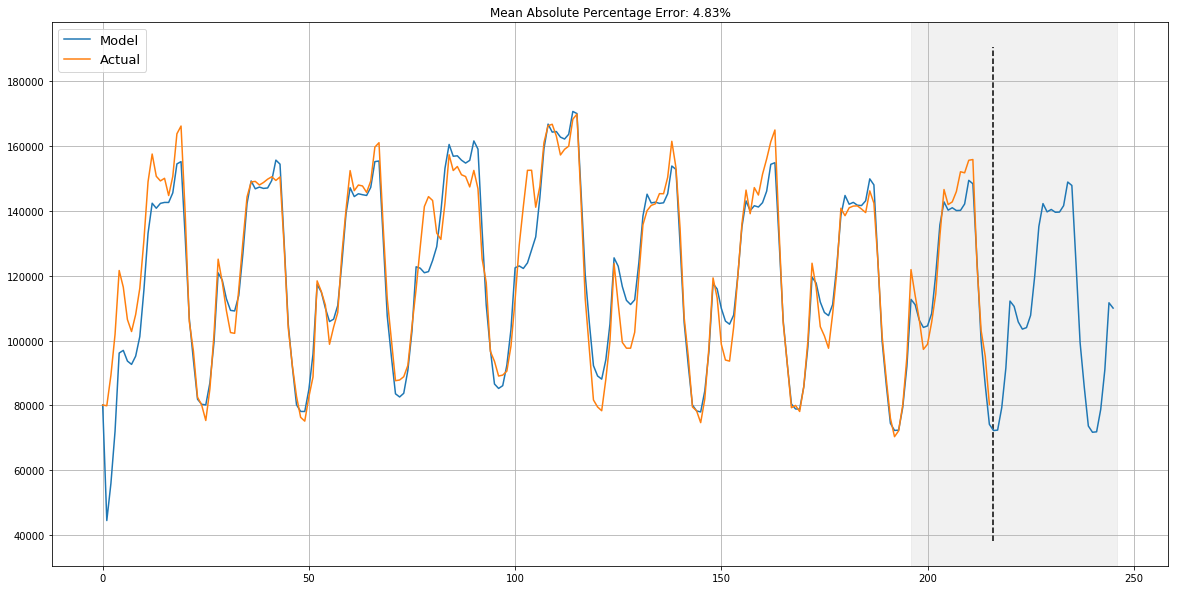

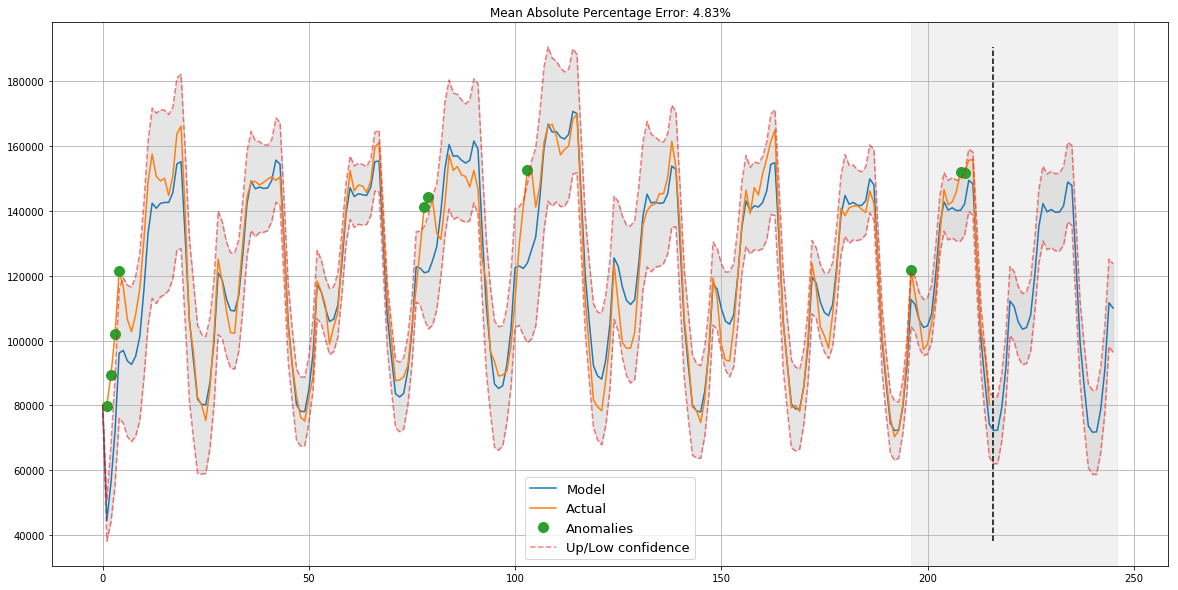

In [40]:
plotHoltWinters(ads.Ads)
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)


**Plot analysis**: HoltWinters model was able to approximate the initial time series, captured the daily seasonality, trends, some of anomalies. 

BTW, model reacts quite sharply to series structure changes, but then quickly returns the deviations to the normal shapes, allowing to build some kind of quick and cheap anomaly detection system for noisy  and raw data.

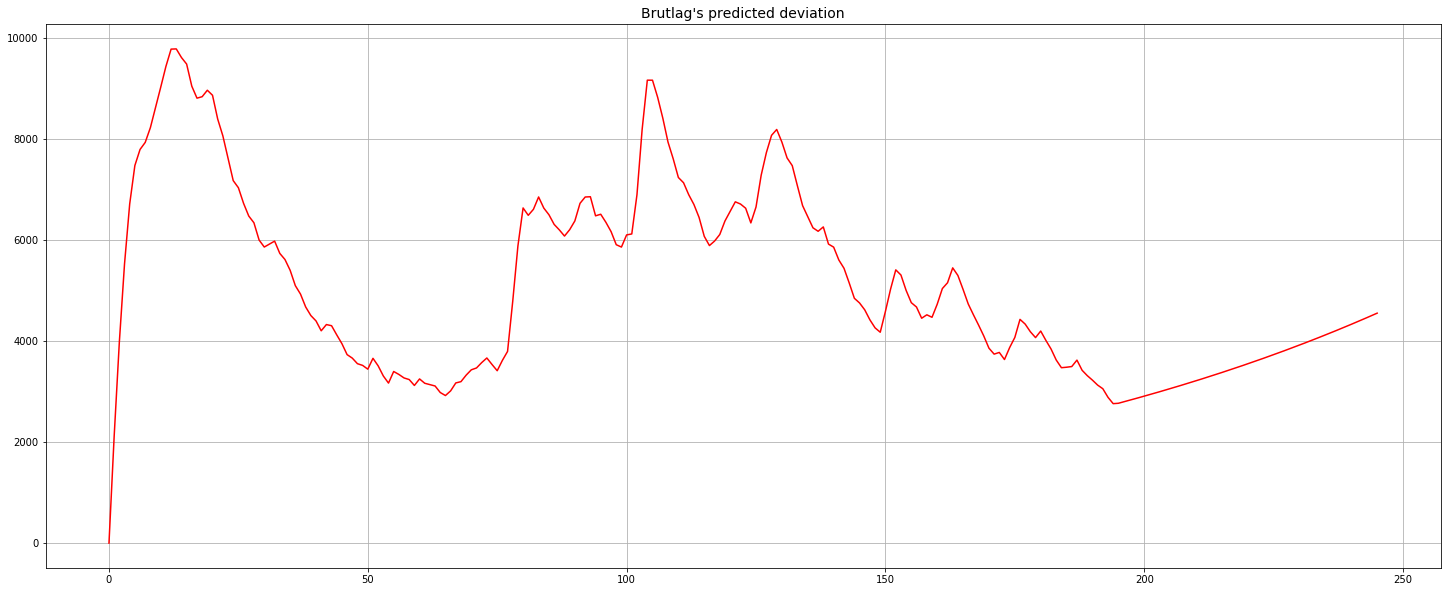

In [48]:
plt.figure(figsize=(25, 10))
plt.plot(model.PredictedDeviation, c='r')
plt.grid(True)
plt.axis()
plt.title("Brutlag's predicted deviation", fontsize=14)

plt.show()

Try HoltWinters model with the second dataset

In [54]:
%%time

# Pick another dataset with another seasonality
data = currency.GEMS_GEMS_SPENT[:-50] 
s_len = 30 
num_preds = 100
scale = 3
# But the same initial parameters
x = [0, 0, 0] 
# scipy.optimize
opt = minimize(timeseries_cv_score, x0=x, 
               args=(data, mean_absolute_percentage_error, s_len), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )
# Get optimized parameters
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)
# 
model = HoltWinters(data, s_len = s_len, alpha = alpha_final, beta = beta_final, gamma = gamma_final, 
                    num_preds = num_preds, scale = scale)
model.triple_exp_smoothing()

40.64013534840272
50.397057623607544
52.13691014276011
40.64013534840272
50.397057623607544
52.13691014276011
40.64012703786612
50.39704241063261
52.13688576277431
40.640135348402296
50.397057623606976
52.136910142759604
40.640135072276095
50.39705712432265
52.136909334638574
40.64011222742511
50.397015299735216
52.13684231469892
40.64011222742511
50.397015299735216
52.13684231469892
40.64010391689541
50.397000086778775
52.136817934740364
40.640112227410604
50.39701529970005
52.13684231462866
40.64011195129859
50.397014800450755
52.136841506578016
27.259980911385657
32.49522884563213
21.373827427654437
27.259980911385657
32.49522884563213
21.373827427654437
27.25997806304218
32.49522707029871
21.373823120530744
27.25997251723113
32.49521494943707
21.373798860927725
27.25998078672066
32.49522876452176
21.373827233990767
27.2599806484908
32.49522852654347
21.37382674573487
27.2599806484908
32.49522852654347
21.37382674573487
27.259977800147333
32.49522675121007
21.373822438611175
27.2599

40.64013534840279
50.39705762360749
52.13691014276003
40.64013507227616
50.39705712432261
52.1369093346385
20.165735509121735
15.999569026721879
17.069933837311645
20.165735509121735
15.999569026721879
17.069933837311645
20.165732237322125
15.99957107495179
17.06990096784322
20.165735354298054
15.999570523996823
17.069930096012925
20.16573543538304
15.999568731004091
17.069933560600465
19.918642928709062
14.150302621491722
12.907784473603524
19.918642928709062
14.150302621491722
12.907784473603524
19.918645222458274
14.150299508686597
12.907781987405883
19.918643939998393
14.150302509998408
12.907783485916816
19.918642873231914
14.150302516395227
12.907784536229599
19.964300821542935
14.251260486046244
12.96819242178659
19.964300821542935
14.251260486046244
12.96819242178659
19.964302270669986
14.251264508464006
12.968192893744595
19.964301858564504
14.251261206335567
12.968192152713595
19.964300759935526
14.251260564413274
12.968192498983539
19.963136357475896
13.998044260812337
12.90

19.6270389957351
13.920980119726298
13.196639217383755
19.627038307153004
13.920980095379429
13.196640528852669
19.627037234122373
13.920979906454981
13.196641835229325
19.627045963858123
13.920981419614098
13.196630902112519
19.627045963858123
13.920981419614098
13.196630902112519
19.62704767198098
13.920982653020344
13.196628338628248
19.62704698340014
13.920981705977239
13.196629650070166
19.62704591036911
13.920981426983076
13.196630956441046
19.62703404694238
13.920979359612723
13.196645787282755
19.62703404694238
13.920979359612723
13.196645787282755
19.62703575506608
13.920979556937352
13.19664322375424
19.627035066484087
13.920979532590136
13.196644535231709
19.627033993453576
13.920979343665568
13.196645841610275
19.627040005426203
13.920980377362508
13.196638344650552
19.627040005426203
13.920980377362508
13.196638344650552
19.627041713549367
13.920980804307506
13.196635781144275
19.62704102496807
13.920980550339726
13.196637092604007
19.62703995193721
13.920980361415364
13.1

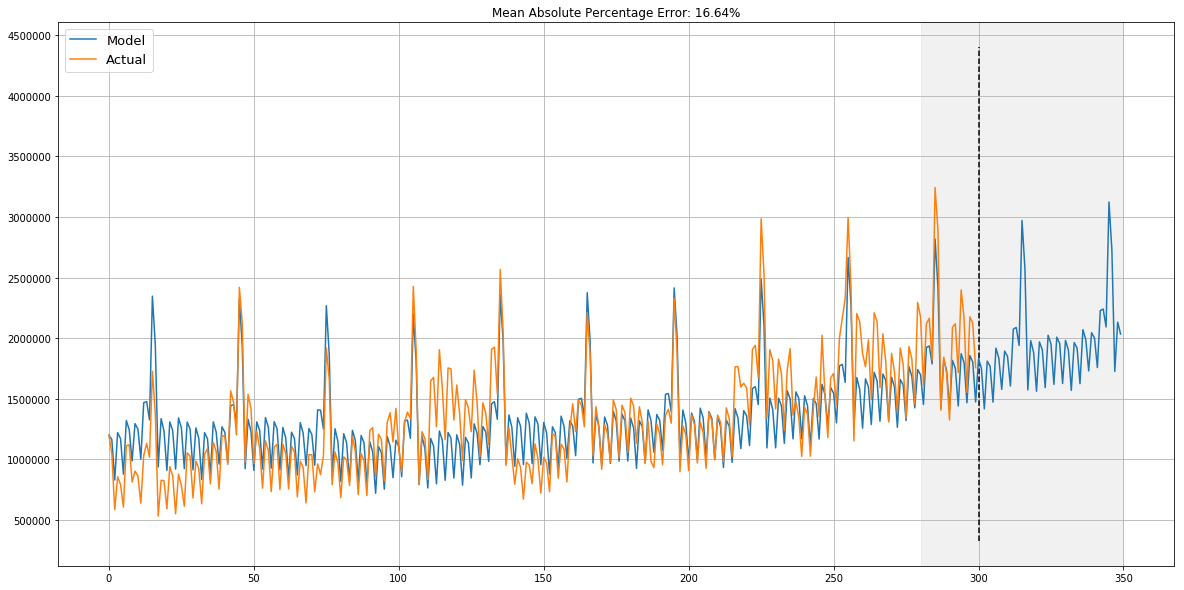

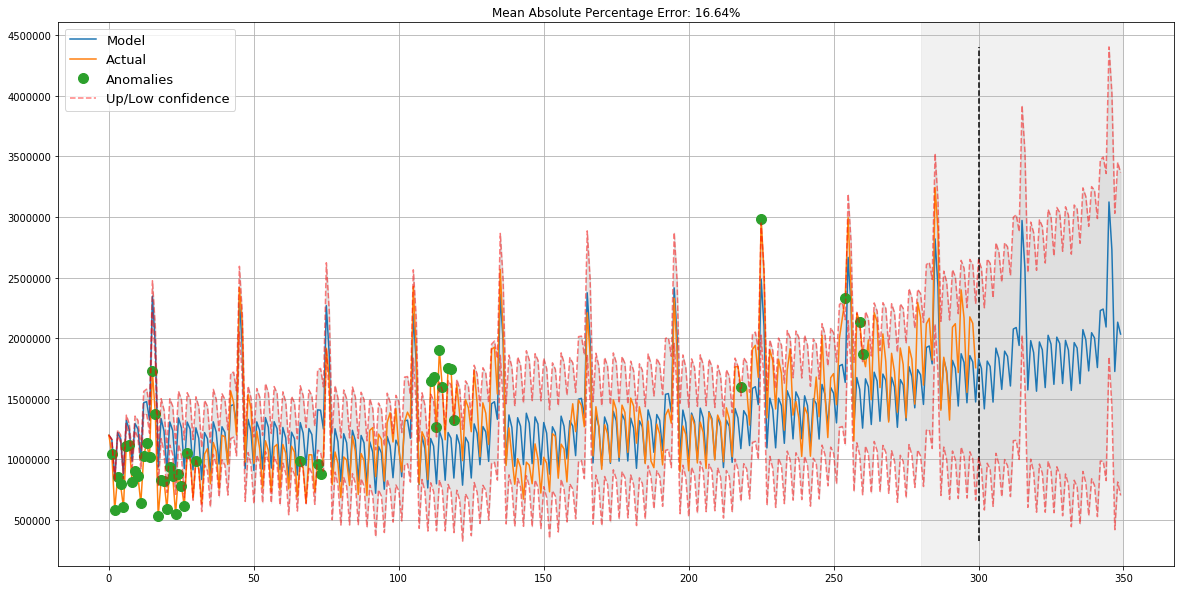

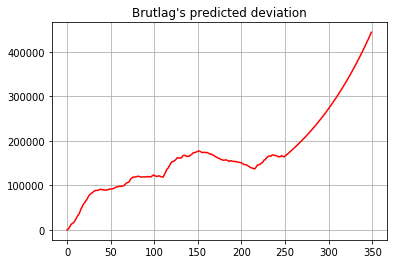

In [59]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

# Brutlag's deviation
plt.figure()
plt.plot(model.PredictedDeviation, c='r')
plt.grid(True)
plt.title("Brutlag's predicted deviation")

plt.show()